In [1]:
# define imports 
import os
import random
import pickle
import sys
import shutil
import numpy as np
import pandas as pd

# import scikit-learn modules 
from sklearn import metrics

# import modules
sys.path.append("../Streamlit")
from ifeatures.fasta_feat import extract_features
from models.dataset import generate_dataset
from models.negatives import sample_neg
from validation.evaluation import eval_cv_scores, sel_model, \
    eval_sampling, validate_model
from validation.domain import search_out_ad

import warnings
warnings.filterwarnings("ignore")

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
# seed the global RNG 
random.seed(SEED)
# seed the global NumPy RNG
np.random.seed(SEED)

In [2]:
# define paths
dataset_path = "../cti_datasets"
tables_path = "../tables"
output_path = "../tmp"
# remove temporary folder if it exists
if os.path.exists(output_path): shutil.rmtree(output_path)
os.mkdir(output_path)

In [3]:
# load dataset of compound-target interactions
cti_df = pd.read_csv(dataset_path + '/AP_CTIs/AP_CT_pairs.csv')
cti_df

,AID,CID,InChIKey,SMILES,GeneID,Symbol,UniProtKB
0,1159518,95717,AIGDHFJPKNZUOR-UHFFFAOYSA-N,C1CC2=C(C=C3C=CC4=C5C3=C2C=CC5=CC=C4)C(=O)C1,4790,NFKB1,P19838
1,1224841,7586,WPYCRFCQABTEKC-UHFFFAOYSA-N,C1C(O1)COC2=CC(=CC=C2)OCC3CO3,2101,ESRRA,P11474
2,1259369,3714831,VLDHWMAJBNWALQ-UHFFFAOYSA-M,C1=CC=C2C(=C1)N=C(S2)[S-].[Na+],2737,GLI3,P10071
3,743077,3224,RDYMFSUJUZBWLH-UHFFFAOYSA-N,C1C2C(COS(=O)O1)C3(C(=C(C2(C3(Cl)Cl)Cl)Cl)Cl)Cl,2099,ESR1,P03372
4,462271,289,YCIMNLLNPGFGHC-UHFFFAOYSA-N,C1=CC=C(C(=C1)O)O,760,CA2,P00918
...,...,...,...,...,...,...,...
3529,1346982,16682746,APQHKWPGGHMYKJ-UHFFFAOYSA-N,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,8856,NR1I2,O75469
3530,1639871,8663,JWAZRIHNYRIHIV-UHFFFAOYSA-N,C1=CC=C2C=C(C=CC2=C1)O,6783,SULT1E1,P49888
3531,1259243,15910,CRQQGFGUEAVUIL-UHFFFAOYSA-N,C(#N)C1=C(C(=C(C(=C1Cl)Cl)Cl)C#N)Cl,367,AR,P10275
3532,743069,4115,IAKOZHOLGAGEJT-UHFFFAOYSA-N,COC1=CC=C(C=C1)C(C2=CC=C(C=C2)OC)C(Cl)(Cl)Cl,2099,ESR1,P03372


In [4]:
# get list of uniprots
uniprots = set(cti_df.UniProtKB)
len(uniprots)

223

In [8]:
# extract target features 
target_feat = extract_features(uniprots, output_path, fit=True)
target_feat

Num. components:  128 
Explained variance:  92.26 % 
Shape:  (223, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
UniProtKB,,,,,,,,,,,,,,,,,,,,,
O00167,11.310851,-0.837330,0.604148,-4.258886,3.232587,3.531070,-1.529355,3.787512,3.292605,-3.247020,...,0.854106,0.946846,-1.497126,3.380147,-0.618099,-0.280049,-1.652292,2.204814,-3.874623,-2.233169
O00574,-12.415026,-18.018542,6.407280,3.709328,3.324697,-7.147749,4.840794,2.430340,-1.638801,-3.758770,...,-2.999027,-1.791601,2.140936,-1.075693,-0.768629,-2.323923,1.937708,1.513917,1.121374,0.738502
O00748,4.450484,-5.297068,2.641880,-5.189892,-0.609643,5.145325,1.671275,-3.265297,2.921954,-6.126268,...,3.322818,1.580786,-2.358978,0.238513,0.667184,0.645463,0.469094,2.225892,1.584311,-1.752119
O14656,-14.485300,-2.827569,0.754521,4.929727,-4.196583,7.961687,6.693239,-0.797371,2.817345,2.940061,...,-0.709059,-1.418506,1.891000,1.869941,-2.857436,-1.457538,-1.188926,0.158856,-1.224524,1.082013
O14842,4.023663,-23.561529,18.145431,-12.870908,-6.018205,2.129879,-5.054050,8.449624,-9.862487,6.121352,...,0.607107,2.595952,-3.218811,0.267160,-0.432089,1.838937,-1.730103,-1.354768,-0.565390,-0.407186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y468,14.392550,2.868866,-5.773163,-3.336286,1.316811,1.925849,-1.231593,2.400525,0.151846,-0.856476,...,1.062549,1.528459,1.303183,-1.196234,2.076745,3.436723,-0.633958,-3.708406,-0.819241,4.361321
Q9Y4K0,-3.887155,-0.375817,-5.231141,-2.506679,2.812303,4.877107,-3.243409,1.338564,-12.869266,-0.468469,...,1.148792,-0.742292,0.875480,0.714341,-1.504464,1.552188,-2.352108,-1.887787,-2.563674,-1.616327
Q9Y5S8,-9.952502,-7.959773,-1.956806,7.051230,-1.313787,1.918578,0.451279,-2.203340,-1.696954,-0.287513,...,-1.973147,1.052844,1.261247,2.687770,0.761253,2.017778,-3.507454,0.344885,0.581974,-3.298236


Generate datasets

In [9]:
# load molecules table
molecules_table = pd.read_csv(tables_path + "/MoleculesTable.csv", encoding = "latin1")
len(molecules_table)

1830

In [10]:
# generate all compound-target pairs
cti_pairs = []
molecules = molecules_table[["Canonical_SMILES", "InChIKey"]].drop_duplicates()
for inch in list(molecules.InChIKey):
    cti_pairs.extend([(inch, t) for t in target_feat.index])
pairs_df = pd.DataFrame(cti_pairs, index=np.repeat(molecules.Canonical_SMILES, len(target_feat.index)))
pairs_df.columns  = ["InChIKey", "UniProtKB"]
pairs_df

,InChIKey,UniProtKB
Canonical_SMILES,,
CCC(C)C1=CC=CC=C1,ZJMWRROPUADPEA-UHFFFAOYSA-N,O00167
CCC(C)C1=CC=CC=C1,ZJMWRROPUADPEA-UHFFFAOYSA-N,O00574
CCC(C)C1=CC=CC=C1,ZJMWRROPUADPEA-UHFFFAOYSA-N,O00748
CCC(C)C1=CC=CC=C1,ZJMWRROPUADPEA-UHFFFAOYSA-N,O14656
CCC(C)C1=CC=CC=C1,ZJMWRROPUADPEA-UHFFFAOYSA-N,O14842
...,...,...
O.O[Si]([O-])([O-])[O-].O[Si]([O-])([O-])[O-].[Mg+2].[Mg+2].[Mg+2],CWBIFDGMOSWLRQ-UHFFFAOYSA-N,Q9Y468
O.O[Si]([O-])([O-])[O-].O[Si]([O-])([O-])[O-].[Mg+2].[Mg+2].[Mg+2],CWBIFDGMOSWLRQ-UHFFFAOYSA-N,Q9Y4K0
O.O[Si]([O-])([O-])[O-].O[Si]([O-])([O-])[O-].[Mg+2].[Mg+2].[Mg+2],CWBIFDGMOSWLRQ-UHFFFAOYSA-N,Q9Y5S8


In [11]:
# generate dataset 
APchem_X, APchem_pairs = generate_dataset(pairs_df, target_feat, "APchem", output_path)

Number of molecules: 1830
Number of targets: 223
############### APDB GLOBAL ####################
F1
LOADING local: ../Streamlit\models/signaturizers/F1
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Parsing SMILES: 1830it [00:00, 11152.00it/s]
Generating signatures:   0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


Generating signatures:   7%|▋         | 1/15 [00:00<00:05,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  13%|█▎        | 2/15 [00:00<00:03,  3.29it/s]

1/1 [==============================] - 0s 24ms/step


Generating signatures:  20%|██        | 3/15 [00:00<00:03,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


Generating signatures:  27%|██▋       | 4/15 [00:01<00:02,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


Generating signatures:  33%|███▎      | 5/15 [00:01<00:02,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  40%|████      | 6/15 [00:01<00:02,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


Generating signatures:  47%|████▋     | 7/15 [00:01<00:02,  3.93it/s]

1/1 [==============================] - 0s 50ms/step


Generating signatures:  53%|█████▎    | 8/15 [00:02<00:01,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  60%|██████    | 9/15 [00:02<00:01,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  67%|██████▋   | 10/15 [00:02<00:01,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  73%|███████▎  | 11/15 [00:02<00:00,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  80%|████████  | 12/15 [00:03<00:00,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  87%|████████▋ | 13/15 [00:03<00:00,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  93%|█████████▎| 14/15 [00:03<00:00,  4.38it/s]

1/1 [==============================] - 0s 46ms/step


Generating signatures: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]

PREDICTION complete!
F2
LOADING local: ../Streamlit\models/signaturizers/F2



Parsing SMILES: 1830it [00:00, 13404.22it/s]
Generating signatures:   0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Generating signatures:   7%|▋         | 1/15 [00:00<00:03,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


Generating signatures:  13%|█▎        | 2/15 [00:00<00:03,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  20%|██        | 3/15 [00:00<00:02,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  27%|██▋       | 4/15 [00:00<00:02,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  33%|███▎      | 5/15 [00:01<00:02,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


Generating signatures:  40%|████      | 6/15 [00:01<00:02,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


Generating signatures:  47%|████▋     | 7/15 [00:01<00:01,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  53%|█████▎    | 8/15 [00:01<00:01,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


Generating signatures:  60%|██████    | 9/15 [00:02<00:01,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  67%|██████▋   | 10/15 [00:02<00:01,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


Generating signatures:  73%|███████▎  | 11/15 [00:02<00:00,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  80%|████████  | 12/15 [00:02<00:00,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  87%|████████▋ | 13/15 [00:03<00:00,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


Generating signatures:  93%|█████████▎| 14/15 [00:03<00:00,  4.11it/s]

1/1 [==============================] - 0s 49ms/step


Generating signatures: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]

PREDICTION complete!
M1
LOADING local: ../Streamlit\models/signaturizers/M1



Parsing SMILES: 1830it [00:00, 15809.50it/s]
Generating signatures:   0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


Generating signatures:   7%|▋         | 1/15 [00:00<00:04,  3.25it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  13%|█▎        | 2/15 [00:00<00:03,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  20%|██        | 3/15 [00:00<00:02,  4.03it/s]

1/1 [==============================] - 0s 23ms/step


Generating signatures:  27%|██▋       | 4/15 [00:01<00:02,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


Generating signatures:  33%|███▎      | 5/15 [00:01<00:02,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


Generating signatures:  40%|████      | 6/15 [00:01<00:02,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  47%|████▋     | 7/15 [00:01<00:01,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


Generating signatures:  53%|█████▎    | 8/15 [00:01<00:01,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  60%|██████    | 9/15 [00:02<00:01,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  67%|██████▋   | 10/15 [00:02<00:01,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


Generating signatures:  73%|███████▎  | 11/15 [00:02<00:00,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  80%|████████  | 12/15 [00:02<00:00,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


Generating signatures:  87%|████████▋ | 13/15 [00:03<00:00,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  93%|█████████▎| 14/15 [00:03<00:00,  4.27it/s]

1/1 [==============================] - 0s 45ms/step


Generating signatures: 100%|██████████| 15/15 [00:03<00:00,  4.24it/s]

PREDICTION complete!
Q1
LOADING local: ../Streamlit\models/signaturizers/Q1



Parsing SMILES: 1830it [00:00, 11990.05it/s]
Generating signatures:   0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


Generating signatures:   7%|▋         | 1/15 [00:00<00:04,  3.15it/s]

1/1 [==============================] - 0s 24ms/step


Generating signatures:  13%|█▎        | 2/15 [00:00<00:03,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  20%|██        | 3/15 [00:00<00:03,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  27%|██▋       | 4/15 [00:01<00:02,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  33%|███▎      | 5/15 [00:01<00:02,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


Generating signatures:  40%|████      | 6/15 [00:01<00:02,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


Generating signatures:  47%|████▋     | 7/15 [00:01<00:02,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  53%|█████▎    | 8/15 [00:02<00:01,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  60%|██████    | 9/15 [00:02<00:01,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


Generating signatures:  67%|██████▋   | 10/15 [00:02<00:01,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  73%|███████▎  | 11/15 [00:02<00:00,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


Generating signatures:  80%|████████  | 12/15 [00:02<00:00,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  87%|████████▋ | 13/15 [00:03<00:00,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


Generating signatures:  93%|█████████▎| 14/15 [00:03<00:00,  4.13it/s]

1/1 [==============================] - 0s 45ms/step


Generating signatures: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]

PREDICTION complete!
Signatures dimension: (1830, 512)
Computing CT pairs


CT pairs dimension: (408090, 640)


In [12]:
# dataset shape 
print(APchem_X.shape, len(APchem_pairs))

(408090, 640) 1830


OCSVM negative sampling

In [13]:
# get list of positive pairs 
cti_pos_pairs = set(zip(cti_df.InChIKey, cti_df.UniProtKB))
len(cti_pos_pairs)

2609

In [14]:
# set class labels
y_lab = np.zeros(len(cti_pairs), dtype=int)
# get indexes of positive class 
pos_idx = [cti_pairs.index(i) for i in cti_pos_pairs]
y_lab[pos_idx] = 1
# create dataframe of labels 
APchem_y = pd.DataFrame({"Class": y_lab}, index = cti_pairs)
APchem_y

,Class
"(ZJMWRROPUADPEA-UHFFFAOYSA-N, O00167)",0
"(ZJMWRROPUADPEA-UHFFFAOYSA-N, O00574)",0
"(ZJMWRROPUADPEA-UHFFFAOYSA-N, O00748)",0
"(ZJMWRROPUADPEA-UHFFFAOYSA-N, O14656)",0
"(ZJMWRROPUADPEA-UHFFFAOYSA-N, O14842)",0
...,...
"(CWBIFDGMOSWLRQ-UHFFFAOYSA-N, Q9Y468)",0
"(CWBIFDGMOSWLRQ-UHFFFAOYSA-N, Q9Y4K0)",0
"(CWBIFDGMOSWLRQ-UHFFFAOYSA-N, Q9Y5S8)",0
"(CWBIFDGMOSWLRQ-UHFFFAOYSA-N, Q9Y6A2)",0


#pos: 2609 
#neg: 405481
Best estimator: OneClassSVM(kernel='linear', nu=0.01) 
Test recall: 0.92
Number of selected negative pairs: 26090


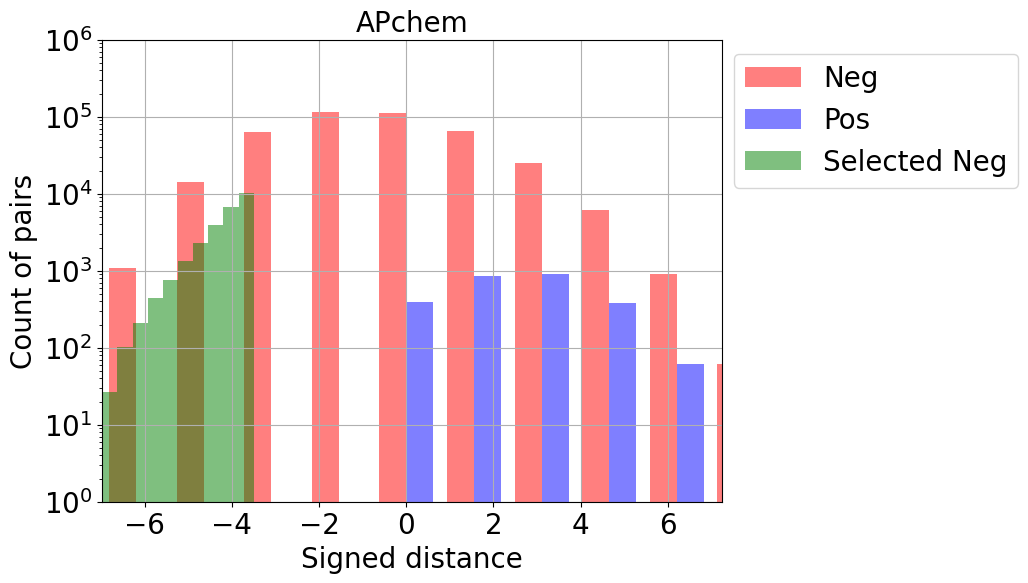

In [16]:
# run negative sampling 
APchem_sampled_X, APchem_sampled_y = sample_neg(APchem_X, APchem_y, "APchem", output_path)

Random negative sampling

In [17]:
# run random negative sampling 
APchem_rnd_X, APchem_rnd_y = sample_neg(APchem_X, APchem_y, "APchem", output_path, rnd=True)

#pos: 2609 
#neg: 405481


Evaluate model performances and select the best estimator

,Metric,Score,Model,Dataset
0,test_roc_auc,0.9999,LR,F1F2
1,test_average_precision,0.9997,LR,F1F2
2,test_recall,0.9937,LR,F1F2
3,test_precision,1.0000,LR,F1F2
4,test_f1,0.9968,LR,F1F2
...,...,...,...,...
115,test_average_precision,0.9988,MLP,CCchem
116,test_recall,0.9918,MLP,CCchem
117,test_precision,0.9987,MLP,CCchem
118,test_f1,0.9952,MLP,CCchem


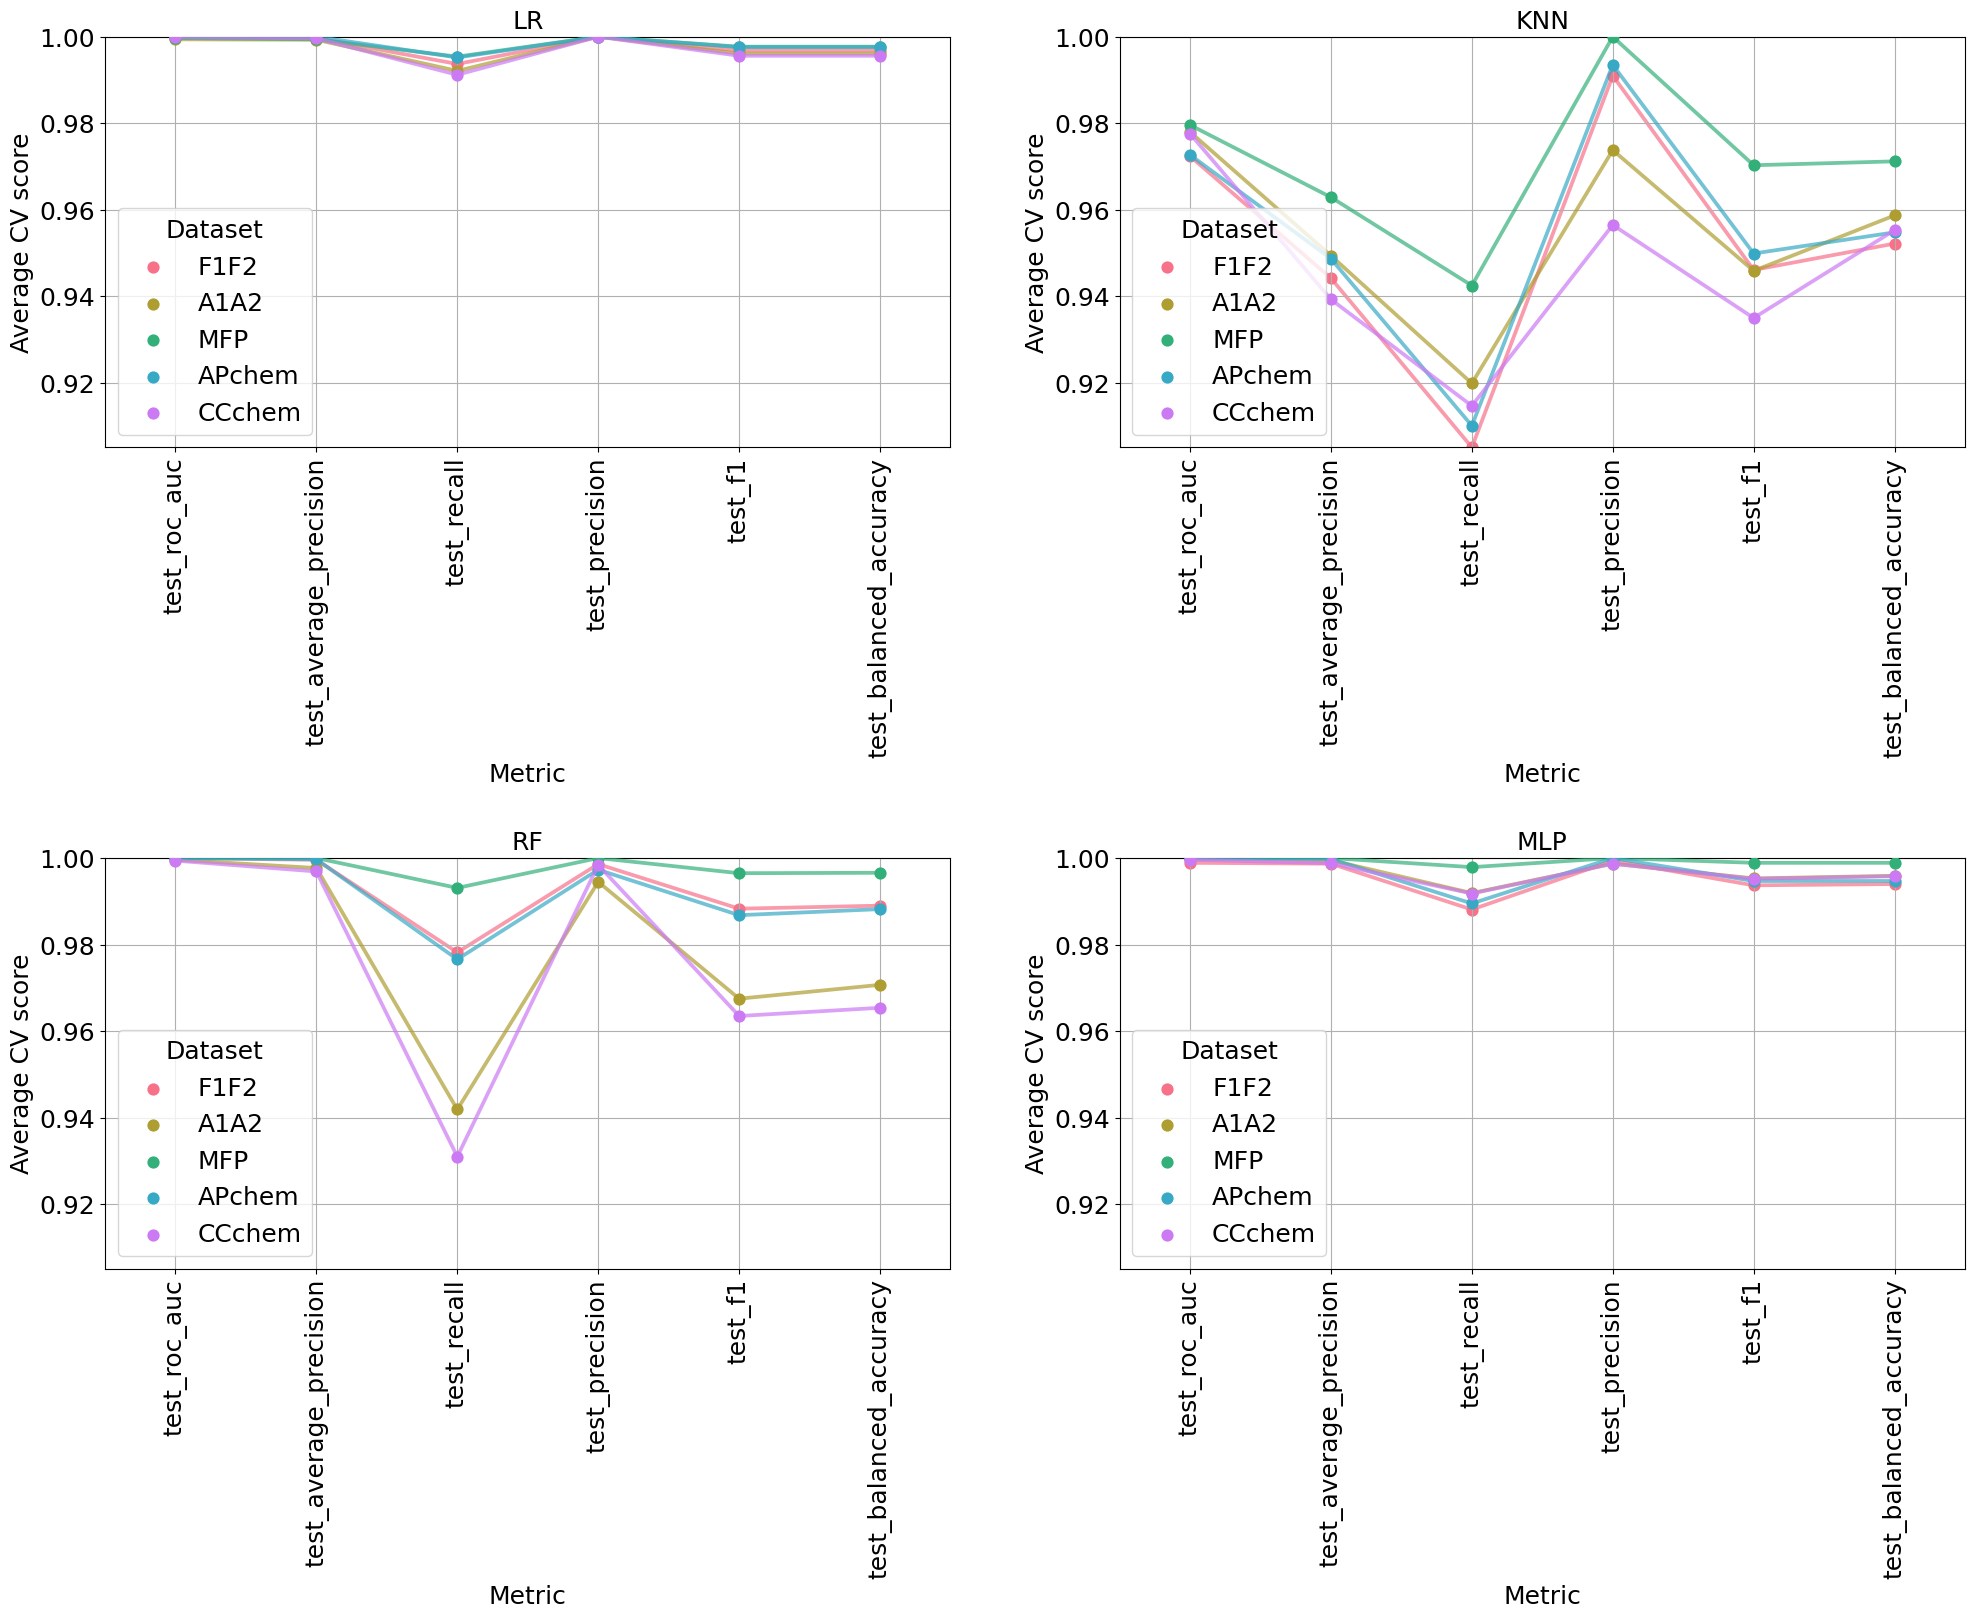

In [6]:
# evaluate performances for each dataset and each model 
datasets = ["F1F2", "A1A2", "MFP", "APchem", "CCchem"]
models = ["lr", "knn", "rf", "mlp"]
cv_scores = eval_cv_scores(datasets, models)
cv_scores

In [9]:
# select model 
final_model = sel_model(APchem_sampled_X, APchem_sampled_y, 
                        "APchem", models, cv_scores, output_path)
final_model

X:  (28699, 640) 
y:  (28699, 1)
Average scores:  {'lr': 0.9984, 'knn': 0.955, 'rf': 0.9914, 'mlp': 0.9964}
Model: LR 
Max score: 0.9984


LogisticRegression(C=10, max_iter=1000, random_state=42)

{10: {'sampled': {'recall': array([1.        , 0.99872286, 0.99872286, ..., 0.00255428, 0.00127714,
          0.        ]),
   'precision': array([0.49682741, 0.49650794, 0.49682338, ..., 1.        , 1.        ,
          1.        ]),
   'average_precision_score': 0.9988712433709118},
  'random': {'recall': array([1.        , 0.99872286, 0.99872286, ..., 0.00255428, 0.00127714,
          0.        ]),
   'precision': array([0.09134391, 0.09125919, 0.09126984, ..., 1.        , 1.        ,
          1.        ]),
   'average_precision_score': 0.7644595209394522}},
 20: {'sampled': {'recall': array([1.        , 0.99872286, 0.99872286, 0.99872286, 0.99872286,
          0.99872286, 0.99872286, 0.99872286, 0.99872286, 0.99872286,
          0.99872286, 0.99872286, 0.99872286, 0.99872286, 0.99872286,
          0.99872286, 0.99872286, 0.99872286, 0.99872286, 0.99872286,
          0.99872286, 0.99872286, 0.99872286, 0.99872286, 0.99872286,
          0.99872286, 0.99872286, 0.99872286, 0.9987228

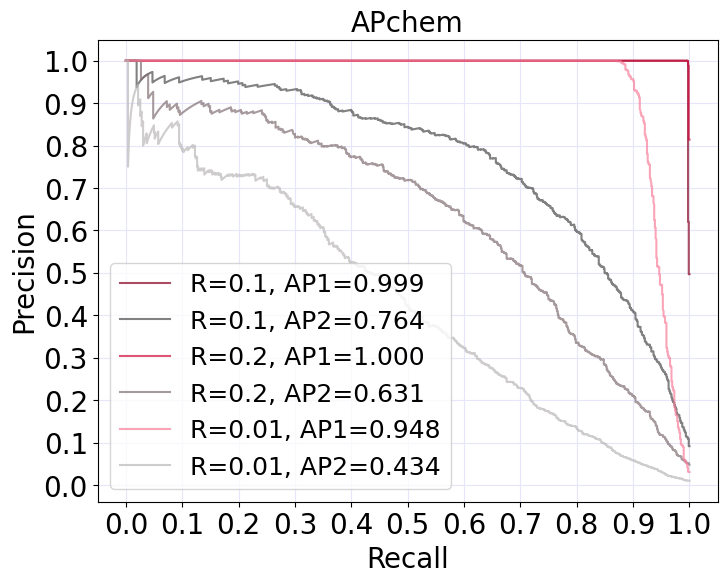

In [36]:
# evaluate sampling strategies (DO NOT RUN)
pr = eval_sampling("APchem", final_model, output_path)
pr

Generate external dataset

In [3]:
# load dataset of compound-target interactions
cti_df = pd.read_csv(dataset_path + '/AP_CTIs/AP_new_CT_pairs.csv')
cti_df.head(10)

,AID,SID,CID,InChIKey,SMILES,Activity Outcome,Target GI,Target GeneID,Symbol,UniProtKB,Activity Value [uM],Activity Name,Assay Name,Assay Type,PubMed ID
0,1645876,144214039,29393,UNAHYJYOSSSJHH-UHFFFAOYSA-N,CCCN(CCC)C1=C(C=C(C=C1[N+](=O)[O-])S(=O)(=O)N)...,Active,NaN,7468,NSD2,O96028,9.6885,Potency,Primary qHTS for inhibitors of nuclear recepto...,Confirmatory,NaN
1,1645877,144214039,29393,UNAHYJYOSSSJHH-UHFFFAOYSA-N,CCCN(CCC)C1=C(C=C(C=C1[N+](=O)[O-])S(=O)(=O)N)...,Active,NaN,7468,NSD2,O96028,12.1972,Potency,Primary qHTS for inhibitors of nuclear recepto...,Confirmatory,NaN
2,1645885,144214039,29393,UNAHYJYOSSSJHH-UHFFFAOYSA-N,CCCN(CCC)C1=C(C=C(C=C1[N+](=O)[O-])S(=O)(=O)N)...,Active,NaN,11069,RAPGEF4,Q8WZA2,89.6936,Potency,Confirmatory qHTS for antagonist of cAMP-regul...,Confirmatory,NaN
3,1645886,144214039,29393,UNAHYJYOSSSJHH-UHFFFAOYSA-N,CCCN(CCC)C1=C(C=C(C=C1[N+](=O)[O-])S(=O)(=O)N)...,Active,NaN,11069,RAPGEF4,Q8WZA2,39.8107,Potency,Validation qHTS for antagonist of cAMP-regulat...,Confirmatory,NaN
4,1798260,49846667,6724,AFPRJLBZLPBTPZ-UHFFFAOYSA-N,C1=CC2=C3C(=C1)C(=O)C(=O)C3=CC=C2,Active,317373446.0,2161,F12,P00748,0.1700,Ki,Enzyme Inhibition Assay from Article 10.1021/j...,Confirmatory,17941623.0
5,1888748,103354777,7018,RJGDLRCDCYRQOQ-UHFFFAOYSA-N,C1C2=CC=CC=C2C(=O)C3=CC=CC=C31,Active,113978.0,4128,MAOA,P21397,1.8900,IC50,Inhibition of recombinant human MAO-A expresse...,Confirmatory,34915314.0
6,1645883,26749349,6697,HUKPVYBUJRAUAG-UHFFFAOYSA-N,C1=CC=C2C(=C1)C3=CC=CC4=C3C(=CC=C4)C2=O,Active,NaN,10411,RAPGEF3,O95398,112.2020,Potency,Validation qHTS for agonist of cAMP-regulated ...,Confirmatory,NaN
7,1802835,49688267,5997,HVYWMOMLDIMFJA-DPAQBDIFSA-N,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Active,88984633.0,23762,OSBP2,Q969R2,0.0600,Kd,Sterol-Binding Assay from Article 10.1074/jbc....,Confirmatory,24742681.0
8,1802835,49688267,5997,HVYWMOMLDIMFJA-DPAQBDIFSA-N,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Active,88984633.0,23762,OSBP2,Q969R2,0.0680,Kd,Sterol-Binding Assay from Article 10.1074/jbc....,Confirmatory,24742681.0
9,1645877,144213965,460,LHGVFZTZFXWLCP-UHFFFAOYSA-N,COC1=CC=CC=C1O,Active,NaN,7468,NSD2,O96028,38.9634,Potency,Primary qHTS for inhibitors of nuclear recepto...,Confirmatory,NaN


In [4]:
# get list of uniprots
uniprots = set(cti_df.UniProtKB)
len(uniprots)

25

In [5]:
# extract target features 
target_feat = extract_features(uniprots, output_path)
target_feat

Explained variance:  92.26 % 
Shape:  (25, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
UniProtKB,,,,,,,,,,,,,,,,,,,,,
O95398,-1.084224,1.260778,-5.752948,-4.009619,-2.419984,0.762638,-1.503140,-4.828506,-1.274714,-0.292946,...,1.425221,0.481081,0.102629,1.135737,-1.353519,0.043998,0.053559,-0.098990,-0.654950,-1.014471
O96028,4.515541,5.458619,-10.095227,4.689865,0.813902,1.096440,-0.975875,4.158221,-7.700306,2.816683,...,1.225894,0.838428,0.617747,0.331025,0.536621,-0.908627,0.511278,1.257187,1.869736,-0.485584
P00748,4.278123,-3.371623,-0.867196,-7.093868,-2.026424,2.748344,-2.523393,3.734108,-9.913194,5.926542,...,-1.512072,0.510785,0.677559,0.185448,2.595227,0.036170,-0.675320,-0.568765,1.152660,2.050015
P04792,4.937619,10.150351,15.295648,-8.610735,-13.185293,-6.245218,-11.590373,4.569681,-4.239915,1.012018,...,0.621544,-0.111594,-0.858688,-0.649944,-1.149080,-1.763879,2.054355,-1.488120,0.372027,-1.548798
P05091,0.593352,1.318076,3.705896,-5.580759,-1.215351,-0.989676,-0.509974,-0.637366,-6.351108,-3.614448,...,2.612257,-0.346603,0.153200,-0.573609,0.534765,0.935532,-0.409016,0.700285,-0.184001,0.954454
P05177,-4.413138,-2.835926,-2.395164,-1.016220,-4.239195,-0.218213,0.752950,-4.412262,1.668974,-6.889410,...,2.140990,0.884817,-2.172677,0.125244,0.090602,-0.565395,1.537888,0.333554,1.582435,0.821568
P08684,-9.759935,-2.867597,-2.473082,4.752932,-0.217798,-2.964924,2.388739,-5.466703,7.692112,-3.124562,...,-3.073545,-0.384569,1.957353,1.247354,-0.858290,4.951140,-3.946029,-0.984997,-1.079197,2.820140
P10071,25.471169,3.475521,-1.935711,-7.409538,-1.775812,-9.841110,4.612031,5.039898,-1.348415,2.346271,...,-0.547316,-0.469234,0.954305,-1.016124,2.312198,-2.004652,0.575191,1.706509,-0.810930,0.378917
P10275,37.720564,-2.318344,-5.751291,0.295218,10.703324,13.638050,-1.746646,5.664024,1.075581,-4.254841,...,0.397043,-0.233355,0.023643,-0.394494,-2.481441,0.517840,1.613173,-2.197758,-2.311018,-2.502338


In [6]:
# get list of pairs 
pairs_df = pd.DataFrame(pd.concat([cti_df.InChIKey, cti_df.UniProtKB], axis=1))
pairs_df.index = cti_df.SMILES
pairs_df.drop_duplicates(inplace=True)
pairs_df.head(5)

,InChIKey,UniProtKB
SMILES,,
CCCN(CCC)C1=C(C=C(C=C1[N+](=O)[O-])S(=O)(=O)N)[N+](=O)[O-],UNAHYJYOSSSJHH-UHFFFAOYSA-N,O96028
CCCN(CCC)C1=C(C=C(C=C1[N+](=O)[O-])S(=O)(=O)N)[N+](=O)[O-],UNAHYJYOSSSJHH-UHFFFAOYSA-N,Q8WZA2
C1=CC2=C3C(=C1)C(=O)C(=O)C3=CC=C2,AFPRJLBZLPBTPZ-UHFFFAOYSA-N,P00748
C1C2=CC=CC=C2C(=O)C3=CC=CC=C31,RJGDLRCDCYRQOQ-UHFFFAOYSA-N,P21397
C1=CC=C2C(=C1)C3=CC=CC4=C3C(=CC=C4)C2=O,HUKPVYBUJRAUAG-UHFFFAOYSA-N,O95398


In [7]:
# generate dataset 
APchem_X, APchem_pairs = generate_dataset(pairs_df, target_feat, "APchem", output_path)

Number of molecules: 21
Number of targets: 25
############### APDB GLOBAL ####################
F1
LOADING local: ../Streamlit\models/signaturizers/F1
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Parsing SMILES: 21it [00:00, 6468.41it/s]
Generating signatures:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


Generating signatures: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

PREDICTION complete!
F2
LOADING local: ../Streamlit\models/signaturizers/F2



Parsing SMILES: 21it [00:00, 5970.34it/s]
Generating signatures:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


Generating signatures: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

PREDICTION complete!
M1
LOADING local: ../Streamlit\models/signaturizers/M1



Parsing SMILES: 21it [00:00, 6206.78it/s]
Generating signatures:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


Generating signatures: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

PREDICTION complete!
Q1
LOADING local: ../Streamlit\models/signaturizers/Q1



Parsing SMILES: 21it [00:00, 10038.79it/s]
Generating signatures:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


Generating signatures: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

PREDICTION complete!
Signatures dimension: (21, 512)
Computing CT pairs
CT pairs dimension: (34, 640)


Validate model performances

In [8]:
# load model
final_model = pickle.load(open(output_path + "/lr.APchem.pkl", "rb"))
# predict new CTIs
y_pred = final_model.predict(APchem_X)
recall_score = np.round(metrics.recall_score(np.ones(len(y_pred)), y_pred), 2)
recall_score

0.97

In [24]:
# define applicability 
APchem_df = pd.DataFrame(APchem_X, index=[(c,t) for c in APchem_pairs.keys() for t in APchem_pairs[c]])
ad_res = search_out_ad("APchem", APchem_df)
ad_res

{'mol': {'UNAHYJYOSSSJHH-UHFFFAOYSA-N': ['positive',
   0.41,
   array(['UNAHYJYOSSSJHH-UHFFFAOYSA-N', 'ZSDSQXJSNMTJDA-UHFFFAOYSA-N',
          'CHIFOSRWCNZCFN-UHFFFAOYSA-N', 'LSIKFJXEYJIZNB-UHFFFAOYSA-N',
          'AVCSMMMOCOTIHF-UHFFFAOYSA-N'], dtype='<U27')],
  'AFPRJLBZLPBTPZ-UHFFFAOYSA-N': ['positive',
   0.28,
   array(['AFPRJLBZLPBTPZ-UHFFFAOYSA-N', 'HUKPVYBUJRAUAG-UHFFFAOYSA-N',
          'GVEPBJHOBDJJJI-UHFFFAOYSA-N', 'HAXBIWFMXWRORI-UHFFFAOYSA-N',
          'FTOVXSOBNPWTSH-UHFFFAOYSA-N'], dtype='<U27')],
  'RJGDLRCDCYRQOQ-UHFFFAOYSA-N': ['positive',
   0.28,
   array(['RJGDLRCDCYRQOQ-UHFFFAOYSA-N', 'RZVHIXYEVGDQDX-UHFFFAOYSA-N',
          'YLQWCDOCJODRMT-UHFFFAOYSA-N', 'NIHNNTQXNPWCJQ-UHFFFAOYSA-N',
          'HUKPVYBUJRAUAG-UHFFFAOYSA-N'], dtype='<U27')],
  'HUKPVYBUJRAUAG-UHFFFAOYSA-N': ['positive',
   0.22,
   array(['HUKPVYBUJRAUAG-UHFFFAOYSA-N', 'GVEPBJHOBDJJJI-UHFFFAOYSA-N',
          'AFPRJLBZLPBTPZ-UHFFFAOYSA-N', 'YLQWCDOCJODRMT-UHFFFAOYSA-N',
          'FTOVXSOBNPWT

In [25]:
# show molecules applicability 
pd.DataFrame(ad_res['mol'])

,UNAHYJYOSSSJHH-UHFFFAOYSA-N,AFPRJLBZLPBTPZ-UHFFFAOYSA-N,RJGDLRCDCYRQOQ-UHFFFAOYSA-N,HUKPVYBUJRAUAG-UHFFFAOYSA-N,HVYWMOMLDIMFJA-DPAQBDIFSA-N,LHGVFZTZFXWLCP-UHFFFAOYSA-N,BJIOGJUNALELMI-ONEGZZNKSA-N,ZRLNBWWGLOPJIC-PYQRSULMSA-N,YCIMNLLNPGFGHC-UHFFFAOYSA-N,QIGBRXMKCJKVMJ-UHFFFAOYSA-N,...,JVZRCNQLWOELDU-UHFFFAOYSA-N,JXSJBGJIGXNWCI-UHFFFAOYSA-N,AFZSMODLJJCVPP-UHFFFAOYSA-N,BQOFWKZOCNGFEC-UHFFFAOYSA-N,WQGWDDDVZFFDIG-UHFFFAOYSA-N,KUAZQDVKQLNFPE-UHFFFAOYSA-N,JPMIIZHYYWMHDT-UHFFFAOYSA-N,LDVVMCZRFWMZSG-UHFFFAOYSA-N,BIWJNBZANLAXMG-UHFFFAOYSA-N,JCYPECIVGRXBMO-UHFFFAOYSA-N
0,positive,positive,positive,positive,positive,positive,positive,negative,positive,positive,...,new,positive,positive,positive,positive,positive,positive,positive,positive,positive
1,0.41,0.28,0.28,0.22,0.27,0.27,0.27,0.03,0.23,0.18,...,0.44,0.36,0.24,0.32,0.29,0.44,0.44,0.33,0.22,0.51
2,"[UNAHYJYOSSSJHH-UHFFFAOYSA-N, ZSDSQXJSNMTJDA-U...","[AFPRJLBZLPBTPZ-UHFFFAOYSA-N, HUKPVYBUJRAUAG-U...","[RJGDLRCDCYRQOQ-UHFFFAOYSA-N, RZVHIXYEVGDQDX-U...","[HUKPVYBUJRAUAG-UHFFFAOYSA-N, GVEPBJHOBDJJJI-U...","[HVYWMOMLDIMFJA-DPAQBDIFSA-N, QYIXCDOBOSTCEI-U...","[LHGVFZTZFXWLCP-UHFFFAOYSA-N, PETRWTHZSKVLRE-U...","[BJIOGJUNALELMI-ONEGZZNKSA-N, PETRWTHZSKVLRE-U...","[ZRLNBWWGLOPJIC-PYQRSULMSA-N, QFBGIDMRCNNMIW-U...","[YCIMNLLNPGFGHC-UHFFFAOYSA-N, WQGWDDDVZFFDIG-U...","[QIGBRXMKCJKVMJ-UHFFFAOYSA-N, ISWSIDIOOBJBQZ-U...",...,"[JUJWROOIHBZHMG-UHFFFAOYSA-N, ROFVEXUMMXZLPA-U...","[JXSJBGJIGXNWCI-UHFFFAOYSA-N, MCWXGJITAZMZEV-U...","[AFZSMODLJJCVPP-UHFFFAOYSA-N, TUBQDCKAWGHZPF-U...","[BQOFWKZOCNGFEC-UHFFFAOYSA-N, WUOACPNHFRMFPN-U...","[WQGWDDDVZFFDIG-UHFFFAOYSA-N, YCIMNLLNPGFGHC-U...","[KUAZQDVKQLNFPE-UHFFFAOYSA-N, MNOILHPDHOHILI-U...","[JPMIIZHYYWMHDT-UHFFFAOYSA-N, DHNRXBZYEKSXIM-U...","[LDVVMCZRFWMZSG-UHFFFAOYSA-N, HKIOYBQGHSTUDB-U...","[BIWJNBZANLAXMG-UHFFFAOYSA-N, FRCCEHPWNOQAEU-U...","[JCYPECIVGRXBMO-UHFFFAOYSA-N, ZRKWMRDKSOPRRS-U..."


In [33]:
# show targets applicability 
pd.DataFrame(ad_res['tg'])

,O96028,Q8WZA2,P00748,P21397,O95398,Q969R2,P22748,P10275,Q92731,P11712,...,Q15822,Q6P988,P18054,P05091,Q99700,P04792,P11473,P10276,P10071,P27338
0,new,in,new,in,new,new,in,positive,positive,positive,...,new,new,in,new,positive,positive,in,positive,positive,in
1,0.47,0.46,0.66,0.5,0.61,0.39,0.66,0.24,0.55,0.4,...,0.46,0.65,0.4,0.66,0.25,0.64,0.54,0.44,0.26,0.51
2,"[P26358, Q9H9B1, Q96QE3, P38398, Q96KQ7]","[Q8WZA2, O75762, O60674, Q13315, P42345]","[P00533, Q96JB6, P58215, Q9Y4K0, P10253]","[P21397, P27338, O60674, Q8WZA2, P53582]","[Q8WZA2, P42345, P04278, Q96JB6, P18054]","[Q9UIF8, Q9UPN9, P06401, P10275, Q96KQ7]","[P22748, P23280, O00748, O75762, Q99549]","[P10275, P06401, Q9UPN9, P18825, Q92830]","[Q92731, P03372, Q96RI1, P11474, P10828]","[P11712, P33261, P11509, Q16696, P04798]",...,"[P43681, P32297, P17787, P30926, P36544]","[P16050, Q96JB6, P18054, P58215, P36544]","[P18054, P16050, O15296, Q14191, O60674]","[P00352, P07954, Q6XQN6, Q8TD30, Q9GZT9]","[Q99700, P10071, P10636, Q01196, Q9UIF8]","[P04792, Q01196, O95467, P00915, P10636]","[P11473, P51449, O75469, P10828, Q14994]","[P10276, Q9UPN9, P19793, P06401, O15164]","[P10071, Q99700, P10636, Q9UIF8, Q01196]","[P27338, P21397, P53582, Q8WZA2, P16050]"


../../cti_datasets/AP_CTIs (34, 640)
../../cti_datasets/B2_B4_CTIs (23, 640)
../../cti_datasets/CTD_CTIs/CYP (1059, 640)
../../cti_datasets/CTD_CTIs/CA (152, 640)


,Recall score,Dataset
0,0.97,PB
1,0.96,B2B4
2,0.99,CYP
3,0.99,CA


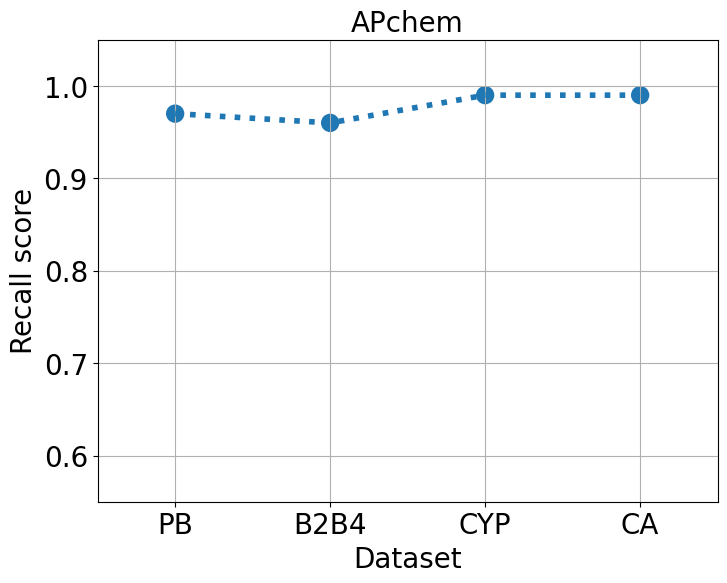

In [13]:
# validate model for each external dataset
recall_scores = validate_model("APchem", final_model)
recall_scores